In [1]:
from common import *
from pandas.api.types import CategoricalDtype
from numba import njit

from sklearn.preprocessing import QuantileTransformer as QT
from scipy.stats import norm
ppf = norm.ppf

import warnings 
warnings.filterwarnings('ignore')

debug = O()
%matplotlib inline
canvas(9,9)

pd.set_option('display.max_columns', 500)

In [2]:
offdiag = lambda a: a[np.where(~np.eye(a.shape[0],dtype=bool))]
nonnans = lambda a: a[np.isfinite(a)]

In [3]:
'''
N0: N without the too high memory columns (the sets of things columns)
N1: N with the sets of things columns turned into actual Python sets
N2: N with changes in this Notebook. It has these columns: [
       'time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'urgency',
       'takeSequence', 'provider', 'bodySize', 'companyCount', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'assetNameId',
       'firstMentionFixed', 'relevance', 'sentimentNegative',
       'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount',
       'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D',
       'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'assetCodesCount', 'subjectsCount', 'audiencesCount', 'groupbyTime',
       'assetNamesCount'
    ]
N2.class: N2 but also with sentimentClass (maxed on duplicates)
''';

In [4]:
M = pd.read_pickle(the_data+'given/M.pkl')
N = pd.read_pickle(big_data+'trans/N0.pkl')
#test = pd.read_pickle(the_data+'/given/test.pkl')

In [5]:
class IdAssign:
    class MISSING():
        pass
    def __init__(self, init, missing=MISSING, name=''):
        self.name = name
        self.map = {}
        if missing is not __class__.MISSING:
            self.map[missing] = -1
        i = 0
        for x in init:
            if x not in self.map and x != missing:
                self.map[x] = i
                i += 1
        self.cache = None
    def __call__(self, key):
        if key not in self.map:
            self.map[key] = len(self.map)
        return self.map[key]
    def __len__(self):
        return self.map.__len__()
    @property
    def series(self):
        if self.cache==len(self):
            return self._series
        self._series = pd.Series(list(self.map.keys()), index=list(self.map.values()), name=self.name)
        self._series.index.name = self.name+'Id'
        self.cache = len(self)
        return self._series

assetCodeSeries = pd.Series(M.assetCode.unique())
assetCodeIdAssign = IdAssign(assetCodeSeries, missing='')
del assetCodeSeries
assetNameSeries = pd.Series(M.assetName.unique())
assetNameIdAssign = IdAssign(assetNameSeries, missing='Unknown')
del assetNameSeries

In [6]:
returns_columns = {
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'cc0', 'returnsOpenPrevMktres1':'oo0',
    'returnsClosePrevRaw10':'cc_10','returnsOpenPrevRaw10':'oo_10',
    'returnsClosePrevMktres10':'cc0_10','returnsOpenPrevMktres10':'oo0_10'
}
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter'
]
column_filter = lambda c: c not in returns_columns and c not in excluded_columns

In [7]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
shortterm = 21
longterm = 250

In [8]:
def add_basic_features(*,M):
    M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign)
    M['assetNameId'] = M.assetName.map(assetNameIdAssign)
    for orig_col, new_col in returns_columns.items():
        M[new_col] = np.log1p(M[orig_col])
    # time features
    M['dayOfYear'] = M.time.dt.dayofyear
    M['dayOfWeek'] = M.time.dt.dayofweek

In [9]:
add_basic_features(M=M)
N['assetNameId'] = N.assetName.map(assetNameIdAssign)

### Code I need to copy elsewhere

In [10]:
def makeMultimap(fr, to):
    ret = {}
    for f, t in zip(fr, to):
        ret.setdefault(f, set()).add(t)
    return ret
assetNameMapCodes = makeMultimap(M.assetNameId, M.assetCodeId)

def makeSinglemap(fr, to):
    ret = {}
    for f, t in zip(fr, to):
        if f in ret:
            assert t==ret[f], 'a "from" element must be mapped to a unique "to" element!'
        else:
            ret[f] = t
    return ret
assetCodeMapName = makeSinglemap(M.assetCodeId, M.assetNameId)


# ------------------------------> looking at `W`

### Scratcher

In [64]:
#pd.to_pickle((F,P), '/big/data/saves/train_5searchbase.32.pkl')
F,P = pd.read_pickle('/big/data/saves/train_5searchbase.32.pkl')

In [46]:
plist = lambda a, **kw: print('['+','.join(str(x) for x in a)+']', **kw)

In [65]:
F.index = P.index = F.index.map(lambda x: '{:x}'.format(x))

In [68]:
from sklearn.model_selection import GroupShuffleSplit

ho = P.quarter>=2015.5
ho.name = None
tr, cv = next(GroupShuffleSplit(n_splits=5, test_size=.5, random_state=44).split(F[~ho], P[~ho], groups=P[~ho].quarter))
_dummy = pd.Series(range(len(P)),index=P.index)
#tr, cv = _dummy.isin(tr), _dummy.isin(cv)

In [71]:
F.index[tr]

Index(['b2e8c', 'b2e8d', 'b2e8e', 'b2e8f', 'b2e90', 'b2e91', 'b2e92', 'b2e93',
       'b2e94', 'b2e95',
       ...
       '321a76', '321a77', '321a78', '321a79', '321a7a', '321a7b', '321a7c',
       '321a7d', '321a7e', '321a7f'],
      dtype='object', length=1346646)

In [72]:
guy = GroupShuffleSplit(n_splits=6, test_size=.5, random_state=44).split(F[~ho], P[~ho], groups=P[~ho].quarter)
for tr, cv in guy:
    plist(P.quarter[_dummy.isin(tr)].unique(), end=',\n')
    plist(P.quarter[_dummy.isin(cv)].unique(), end='\n\n')

[2009.0,2009.75,2010.75,2011.5,2012.25,2012.5,2012.75,2013.0,2013.25,2013.75,2014.0,2014.25,2015.0],
[2009.25,2009.5,2010.0,2010.25,2010.5,2011.0,2011.25,2011.75,2012.0,2013.5,2014.5,2014.75,2015.25]

[2009.25,2009.5,2011.0,2011.25,2011.5,2011.75,2012.0,2012.25,2013.0,2013.5,2014.5,2014.75,2015.0],
[2009.0,2009.75,2010.0,2010.25,2010.5,2010.75,2012.5,2012.75,2013.25,2013.75,2014.0,2014.25,2015.25]

[2011.0,2011.75,2012.0,2012.25,2012.75,2013.25,2013.5,2014.0,2014.25,2014.5,2014.75,2015.0,2015.25],
[2009.0,2009.25,2009.5,2009.75,2010.0,2010.25,2010.5,2010.75,2011.25,2011.5,2012.5,2013.0,2013.75]

[2009.5,2010.0,2010.25,2010.5,2011.0,2011.75,2012.25,2012.5,2013.0,2013.5,2014.25,2014.75,2015.25],
[2009.0,2009.25,2009.75,2010.75,2011.25,2011.5,2012.0,2012.75,2013.25,2013.75,2014.0,2014.5,2015.0]

[2009.75,2010.0,2010.25,2010.75,2011.75,2012.0,2012.25,2012.5,2013.0,2013.5,2013.75,2014.5,2015.0],
[2009.0,2009.25,2009.5,2010.5,2011.0,2011.25,2011.5,2012.75,2013.25,2014.0,2014.25,2014.75,2015.

#### stock subsets

In [11]:
Mt = M[M.time>=train_start_time]

In [12]:
inUniCount = Mt.groupby('assetCodeId').universe.sum()
stocksInUni = (inUniCount != 0).pipe(lambda x: x.index[x])
assert stocksInUni.is_monotonic
xStocksInUni = set(stocksInUni) #EDITCELL

In [13]:
W = O()
W.y = Mt[['time','assetCodeId','oo_10']].pivot('time','assetCodeId').oo_10
W.y0 = Mt[['time','assetCodeId','oo0_10']].pivot('time','assetCodeId').oo0_10
W.u = Mt[['time','assetCodeId','universe']].pivot('time','assetCodeId').universe.fillna(0).astype(int)

In [38]:
C = O()
C.y = W.y.corr()
C.y0 = W.y0.corr()
C.u = W.u.T @ W.u

In [91]:
@njit
def offdiag_items(ix, x, y):
    m, n = x.shape
    assert (m, n) == y.shape
    assert m == n
    assert (m,) == ix.shape
    t = (n**2-n) // 2
    I = np.full(t, -1, dtype=np.int64)
    J = np.full(t, -1, dtype=np.int64)
    X = np.full(t, 0, dtype=x.dtype)
    Y = np.full(t, 0, dtype=y.dtype)
    k = -1
    for i in range(m):
        for j in range(i+1, n):
            k += 1
            I[k] = ix[i]
            J[k] = ix[j]
            X[k] = x[i,j]
            Y[k] = y[i,j]
    return I, J, X, Y

In [114]:
C.v = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y.index.values, C.y.values, C.u.values))))
C.v0 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y0.index.values, C.y0.values, C.u.values))))

In [127]:
C.v[C.v0.Unic>=1500].sort_values('Corr', ascending=False).Corr.pipe(lambda x: sum(x>.65))

2552

In [105]:
assetCodeIdAssign.series[301]

'CMCSA.O'

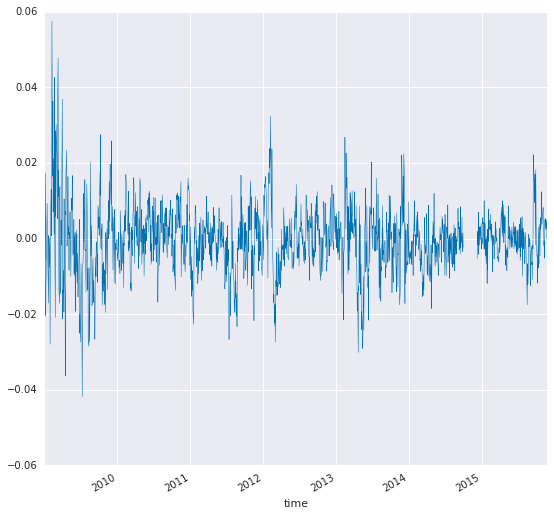

In [110]:
(W.y0[301]-W.y0[302]).plot(linewidth=.5);

# ------------------------------> looking at `N`